# Notebook Intentions

The purpose of this notebook is to simulate an amusement park. 


In [2]:
from park import Park
from behavior_reference import BEHAVIOR_ARCHETYPE_PARAMETERS
import pandas as pd
from tabulate import tabulate
from multiprocessing import cpu_count, Pool
from simulation_utils import simulate
from park_utils import get_average_wait_times, get_park_average_wait_times

### Book Keeping

    - Version: dictates the location performance graphs are stored
    - Verbosity: controls much information is displayed during a simulation, increase to show more info
    - Show Plots: controls whether park plots are displayed in this notebook
    - RNG Seed: seeds random number generators to enforce identical results across runs/machines
    

In [3]:
VERSION = "20K All FP - MIKE"
VERBOSITY = 0
SHOW_PLOTS = True


## Park
 
The park contains Agents, Attractions and Activities.

- Total Daily Agents: dictates how many agents visit the park within a day
- Hourly Percent: dictates what percentage of Total Daily Agents visits the park at each hour
- Perfect Arrivals: enforces that the exact amount of Total Daily Agents arrives during the day
- Expedited Pass Ability Percent: percent of agents aware of expeditied passes
- Expedited Threshold: acceptable queue wait time length before searching for an expedited pass
- Expedited Limit: total number of expedited pass an agent can hold at any given time


In [4]:
TOTAL_DAILY_AGENTS = 40000
PERFECT_ARRIVALS = True
HOURLY_PERCENT = {
    "10:00 AM": 10,
    "11:00 AM": 20,
    "12:00 AM": 17,
    "3:00 PM": 20,
    "4:00 PM": 15,
    "5:00 PM": 10,
    "6:00 PM": 1,
    "7:00 PM": 5,
    "8:00 PM": 1,
    "9:00 PM": 1,
    "10:00 PM": 0,
    "11:00 PM": 0,
    "12:00 PM": 0
}
EXP_ABILITY_PCT = 0.7
EXP_THRESHOLD = 1
EXP_LIMIT = 1

## Agents

The park is populated by agents. Agents visit attractions and activities. They make decisions about where to go based on their preferences, the popularity of attractions and activities and waiting times. Each Agent has a behavioral archetype.

- Ride Enthusiast: wants to stay for a long time, go on as many attractions as possible, doesn't want to visit activites, doesn't mind waiting
- Ride Favorer: wants to go on a lot of attractions, but will vists activites occasionally, will wait for a while in a queue
- Park Tourer: wants to stay for a long time and wants to see attractions and activities equally, reasonable about wait times
- Park Visitor: doesn't want to stay long and wants to see attractions and activities equally, inpatient about wait times
- Activity Favorer: doesn't want to stay long and prefers activities, reasonable about wait times
- Activity Enthusiast: wants to visit a lot of activities, reasonable about wait times

Archetypes can be tweaked and new archetypes can be added in `behavior_reference.py`. 

- Agent Archetype Distribution: dictates the probability an agent will have a particular behavioral archetype


In [5]:
AGENT_ARCHETYPE_DISTRIBUTION = {
    "ride_enthusiast": 10,
    "ride_favorer": 0,
    "park_tourer": 70,
    "park_visitor": 0,
    "activity_favorer": 20,
    "activity_enthusiast": 0,
}


## Attractions

Attractions are essentially rides within a park. 

- Attractions: list of dictionaries that describe the attractions within the park
    - Name: name of the attraction
    - Run Time: How long the attraction take to run, in minutes
    - Capacity: Maximium number of agents that can be on the attraction during a run
    - Popularity: Value from 1-10 that describes how popular an attraction is with respect to other attractions
    - Expedited Queue: Dictates whether the attraction has an expedited queue or not
    - Expedited Queue Ratio: Dictates what percentage of attraction capacity is devoted to members of the expedited queue
    - Child Eligible: Dictates whether children can ride the attraction
    - Adult Eligible: Dictates whether adults can ride the attraction

In [6]:
ATTRACTIONS = [
    {
        "name": "Python",
        "run_time": 2, #2.133
        "hourly_throughput": 1440,
        "popularity": 6.875,
        "expedited_queue": False,   #
        "expedited_queue_ratio": 0.99,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 45,
    },
    {
        "name": "Joris en de Draak",
        "run_time": 2,
        "hourly_throughput": 1700,
        "popularity": 9.113, 
        "expedited_queue": False,   #
        "expedited_queue_ratio": 0.99,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 56,
    },
    {
        "name": "Vliegende Hollander",
        "run_time": 4, #3.7167
        "hourly_throughput": 1900,
        "popularity": 10,
        "expedited_queue": False,  #
        "expedited_queue_ratio": 0.99,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 53.4,
    },
    {
        "name": "Baron 1898",
        "run_time": 2, #2.16666666666
        "hourly_throughput": 900,
        "popularity": 4.756, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 59.5,
    },
    {
        "name": "Kinderspoor",
        "run_time": 2,
        "hourly_throughput": 420,
        "popularity": 1.176, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 21,
    },
    {
        "name": "De oude tufferbaan",
        "run_time": 4,
        "hourly_throughput": 1200,
        "popularity": 4.774,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 30,
    },
    {
        "name": "Halve maan",
        "run_time": 3,
        "hourly_throughput": 1200,
        "popularity": 4.856,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 31.4,
    },
    {
        "name": "Pirana",
        "run_time": 7, #6.5
        "hourly_throughput": 2000,
        "popularity": 8.897, 
        "expedited_queue": False,   #
        "expedited_queue_ratio": 0.99,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 36.4,
    },
    {
        "name": "Max & Moritz",
        "run_time": 2, #1.5
        "hourly_throughput": 1800,
        "popularity": 8.363, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 41.4,
    },
    {
        "name": "Fata Morgana",
        "run_time": 8,
        "hourly_throughput": 1600,
        "popularity": 6.47, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 29.3,
    },
    {
        "name": "Fabula",
        "run_time": 17,
        "hourly_throughput": 1760,
        "popularity": 6.087, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 16.7,
    },
    {
        "name": "Volk_van_Laaf_(Monorail)",
        "run_time": 7,
        "hourly_throughput": 425,
        "popularity": 1.390,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 30.4,
    },
    {
        "name": "Stoomcarrousel",
        "run_time": 2,
        "hourly_throughput": 400,
        "popularity": 1,
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 16,
    },
    {
        "name": "Droomvlucht",
        "run_time": 6,
        "hourly_throughput": 1775,
        "popularity": 8.447, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 44.4,
    },
    {
        "name": "Villa_Volta",
        "run_time": 10,
        "hourly_throughput": 1200,
        "popularity": 4.511, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 26,
    },
    {
        "name": "Sirocco",
        "run_time": 8,
        "hourly_throughput": 1000,
        "popularity": 4, #3.502
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 20.3,
    },
    {
        "name": "Vogel_Rok",
        "run_time": 2, #1.520
        "hourly_throughput": 1600,
        "popularity": 6.680, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 32,
    },
    {
        "name": "Carnaval_Festival",
        "run_time": 8,
        "hourly_throughput": 1750,
        "popularity": 7.062, 
        "expedited_queue": False,
        "expedited_queue_ratio": 0.8,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 28.6,
    },
    {
        "name": "Symbolica",
        "run_time": 10,
        "hourly_throughput": 1400,
        "popularity": 6.779, 
        "expedited_queue": False,  #
        "expedited_queue_ratio": 0.99,
        "child_eligible": True,
        "adult_eligible": True,
        "expected_wait_time": 46.6,
    }
]

## Activities
Activities are everything to do within the park that isn't an attraction. 

- Activities: list of dictionaries that describe activities within the park
    - Name: name of the activity
    - Popularity: Value from 1-10 that describes how popular an activity is with respect to other activities
    - Mean Time: The expected time agents will spend at an activity

In [7]:
ACTIVITIES = [
    {
      "name": "sightseeing",
      "popularity": 5,
      "mean_time": 5
    },
    {
      "name": "show",
      "popularity": 5,
      "mean_time": 30
    },
    {
      "name": "merchandise",
      "popularity": 5,
      "mean_time": 30
    },
    {
      "name": "food",
      "popularity": 5,
      "mean_time": 45
    }
  ]

## Plots

Set the Y limit of plots

In [8]:
PLOT_RANGE = {
    "Attraction Queue Length": 40000,
    "Attraction Wait Time": 100,
    "Attraction Expedited Queue Length": 6000,
    "Attraction Expedited Wait Time": 500,
    "Activity Vistors": 20000,
    "Approximate Agent Distribution (General)": 1.0,
    "Approximate Agent Distribution (Specific)": 1.0,
    "Attraction Average Wait Times": 120,
    "Agent Attractions Histogram": 1.0,
    "Attraction Total Visits": 46000,
    "Expedited Pass Distribution": 150000,
    "Age Class Distribution": 20000,
}

## Simulation

Run the simulation here.

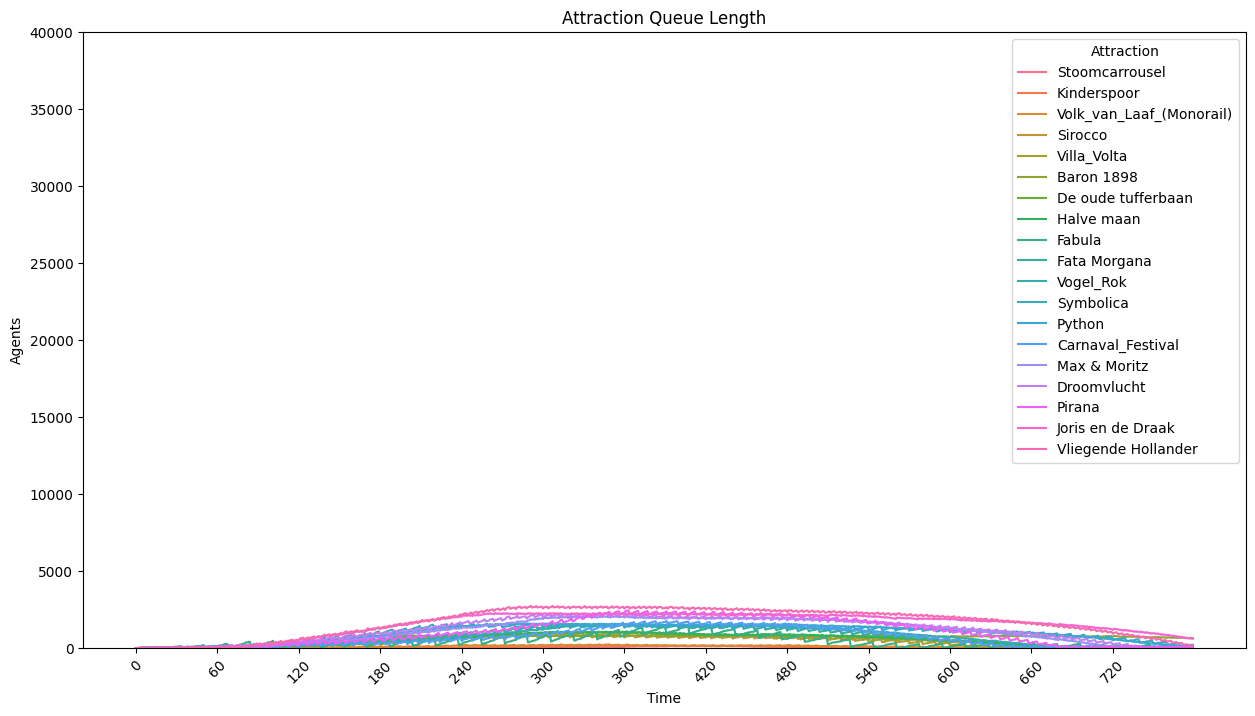

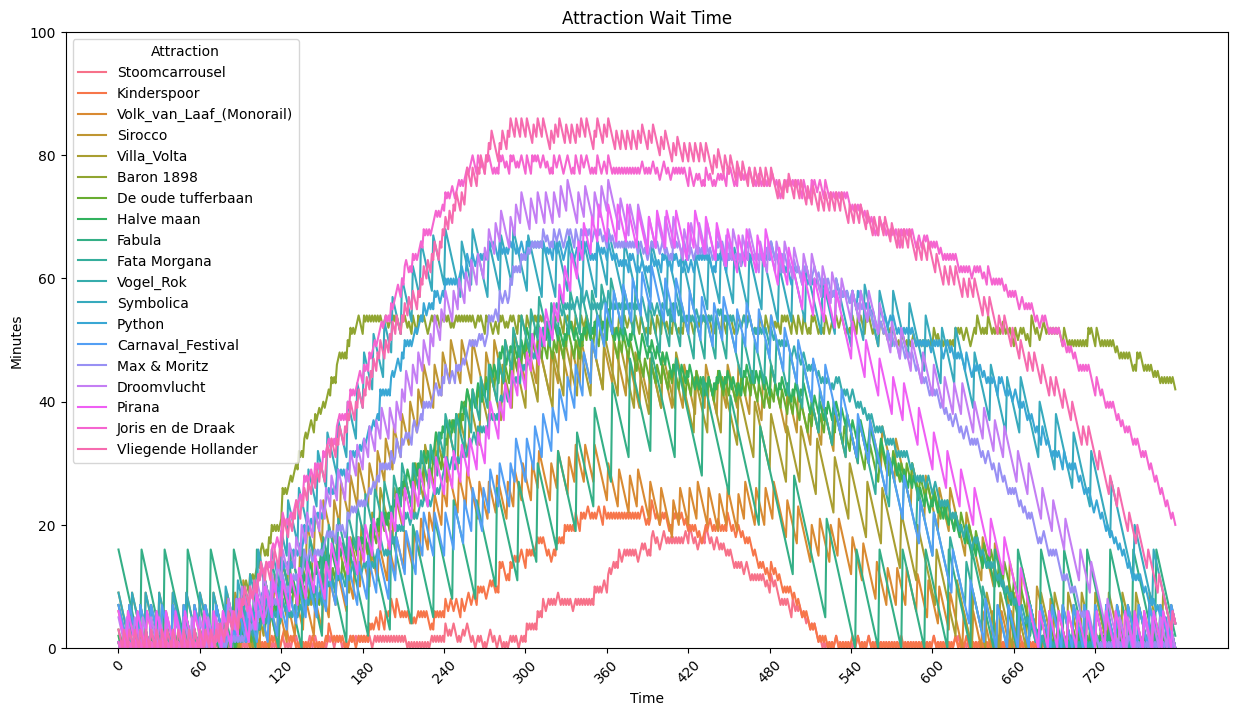

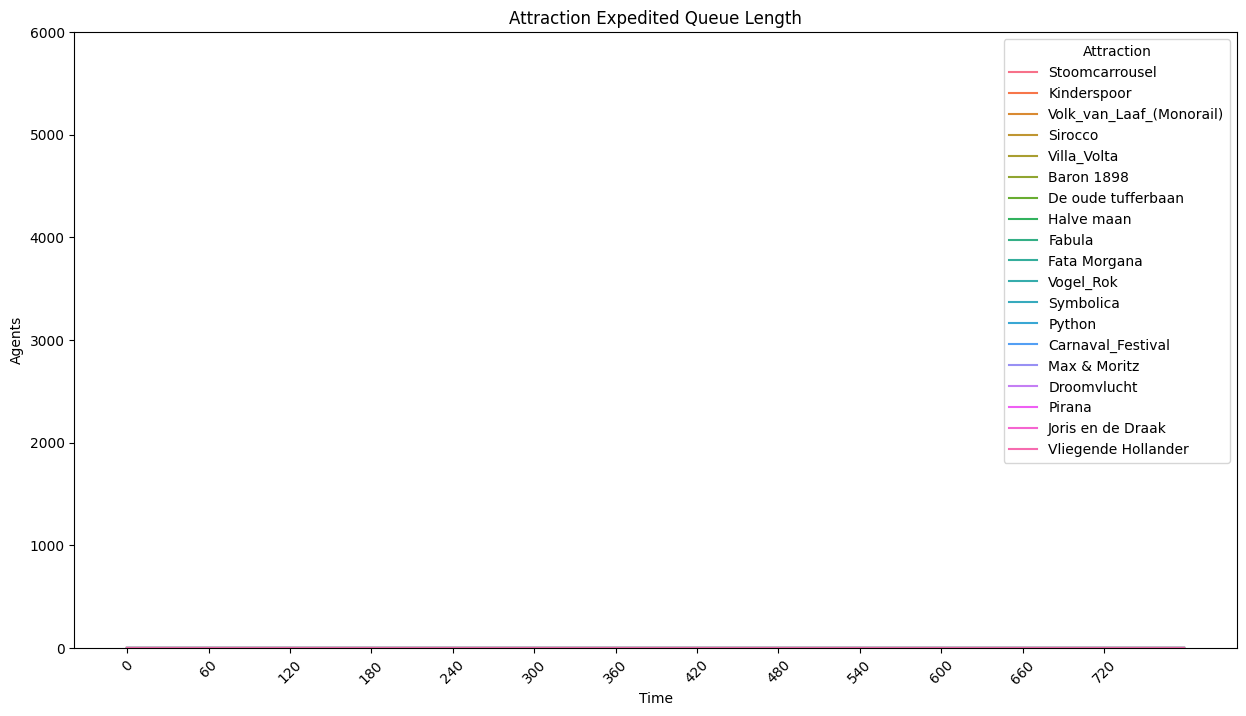

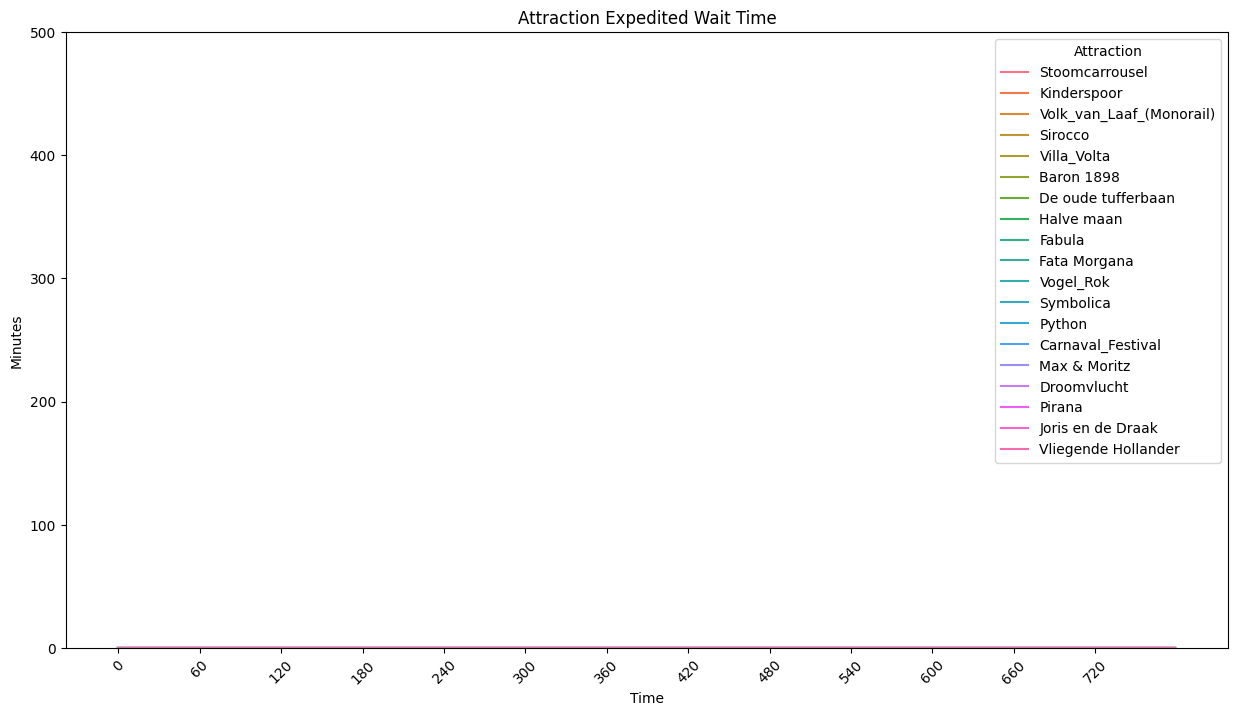

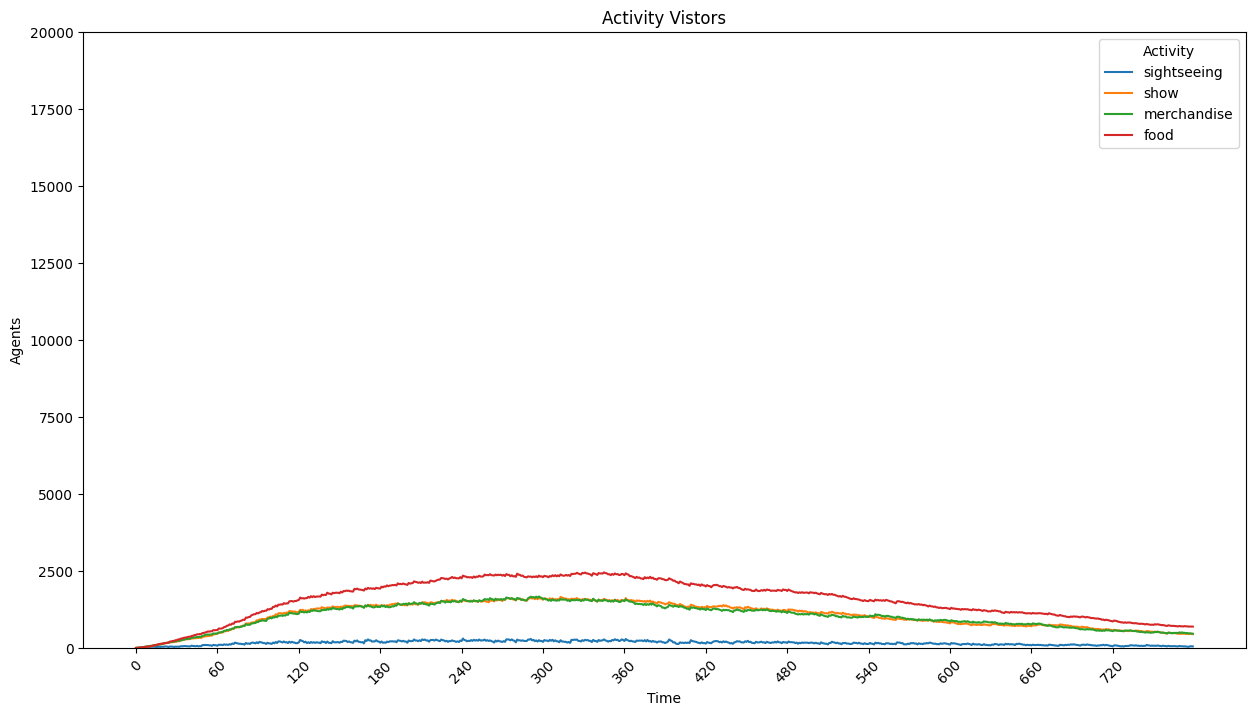

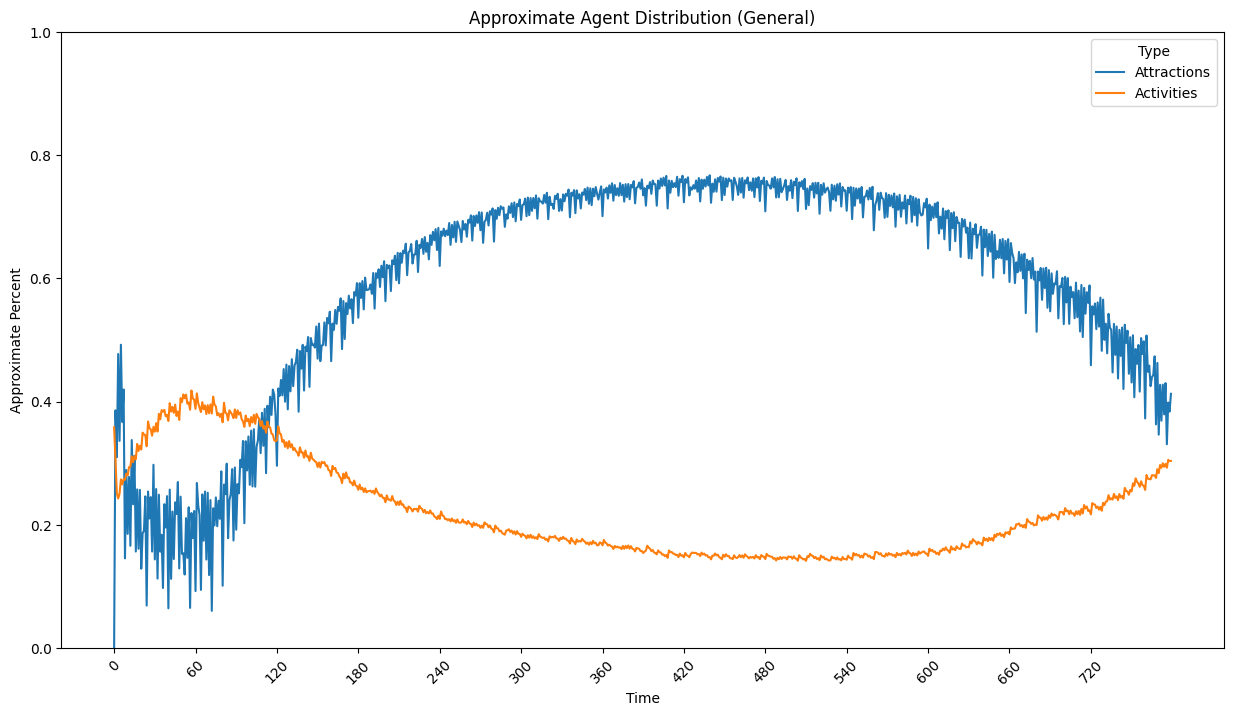

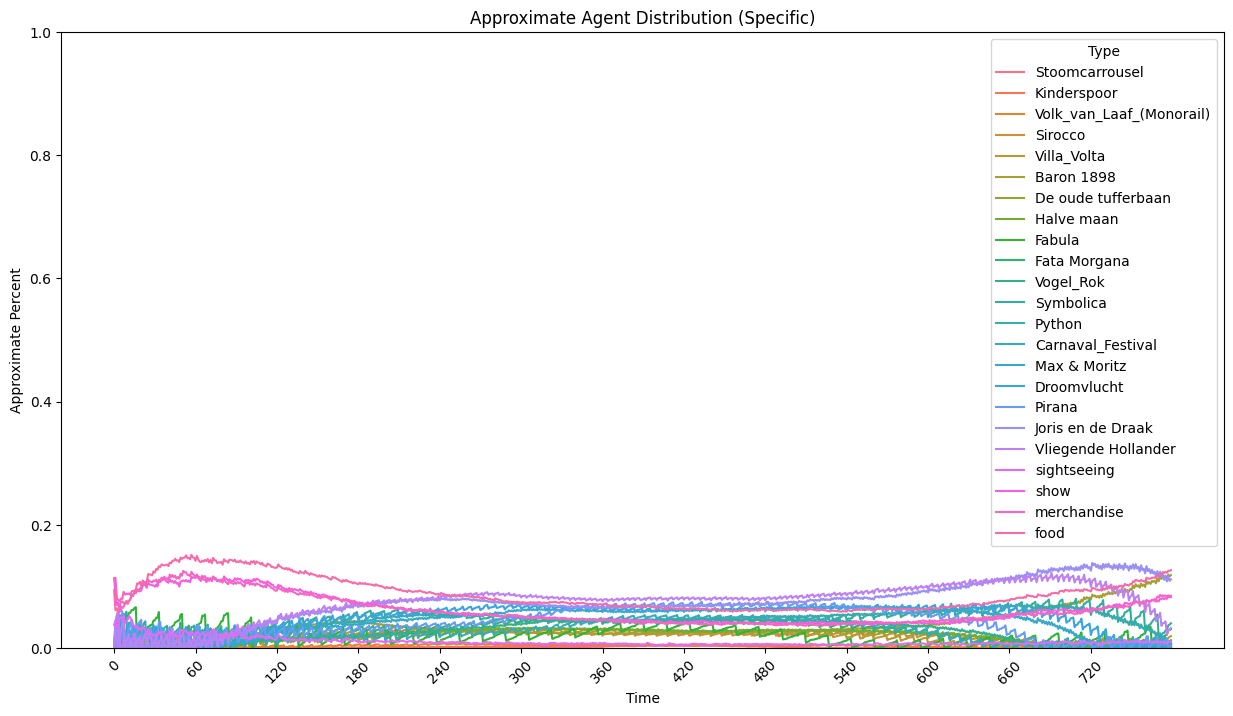

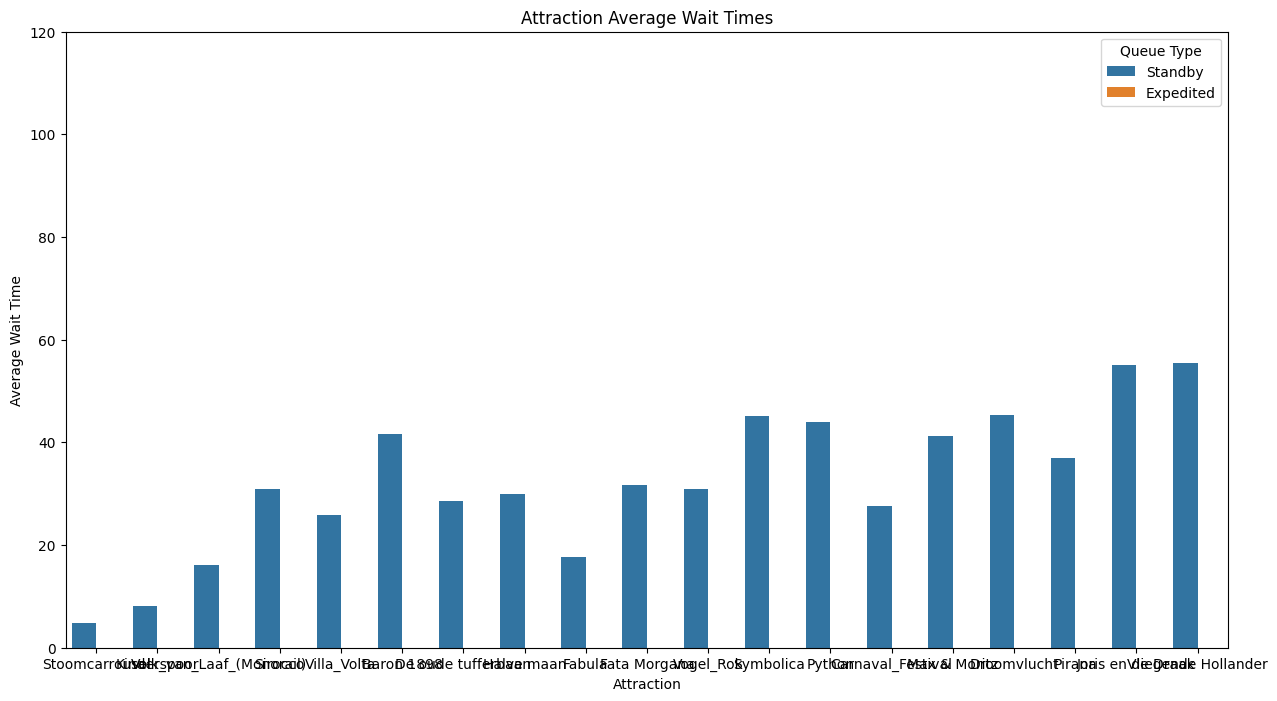

+--------------------------+---------------------+--------------+
| Attraction               |   Average Wait Time | Queue Type   |
|--------------------------+---------------------+--------------|
| Vliegende Hollander      |                0.00 | Expedited    |
| Vogel_Rok                |                0.00 | Expedited    |
| Fata Morgana             |                0.00 | Expedited    |
| Carnaval_Festival        |                0.00 | Expedited    |
| Fabula                   |                0.00 | Expedited    |
| Halve maan               |                0.00 | Expedited    |
| Max & Moritz             |                0.00 | Expedited    |
| De oude tufferbaan       |                0.00 | Expedited    |
| Python                   |                0.00 | Expedited    |
| Droomvlucht              |                0.00 | Expedited    |
| Baron 1898               |                0.00 | Expedited    |
| Sirocco                  |                0.00 | Expedited    |
| Pirana  

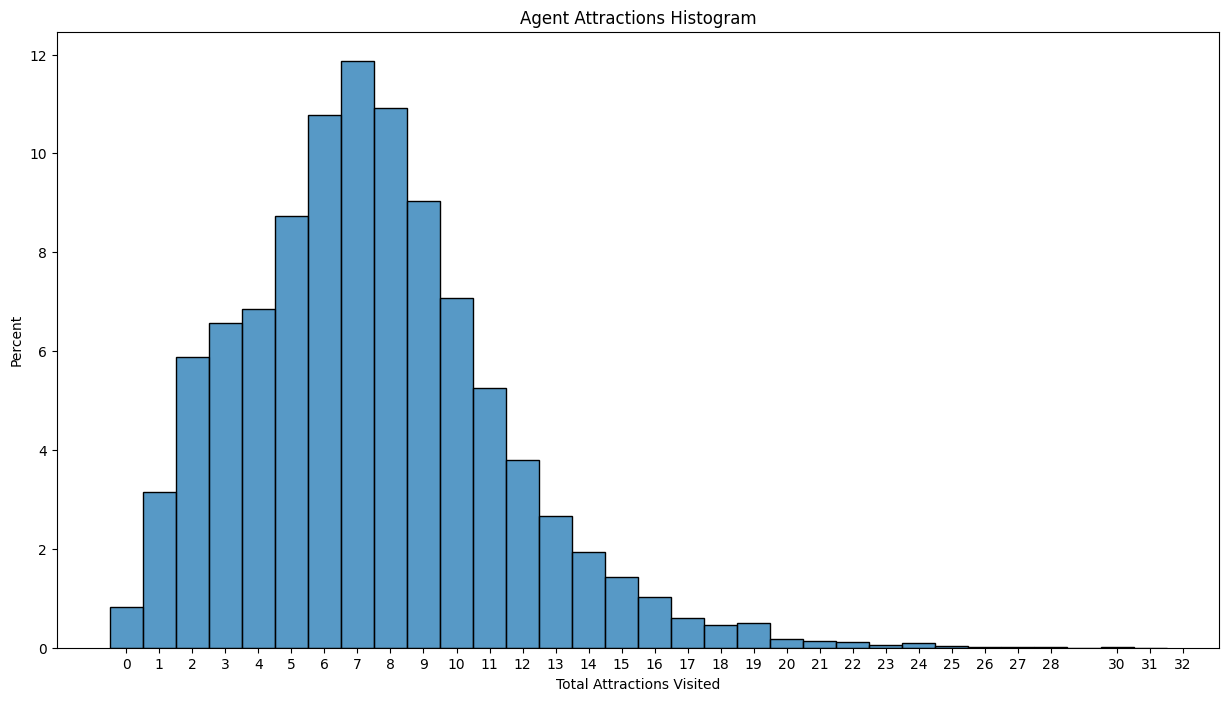

+----------+-----------------------------+
| Metric   |   Total Attractions Visited |
|----------+-----------------------------|
| count    |                    40000.00 |
| mean     |                        7.38 |
| std      |                        3.86 |
| min      |                        0.00 |
| 25%      |                        5.00 |
| 50%      |                        7.00 |
| 75%      |                       10.00 |
| max      |                       32.00 |
+----------+-----------------------------+


F:\School\TUe\Year 1\Quarter3\QuantativeEvaluation\ShapelandEfteling\Code\park.py:336: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x=x, y=y, hue=hue, ci=None, estimator=estimator)


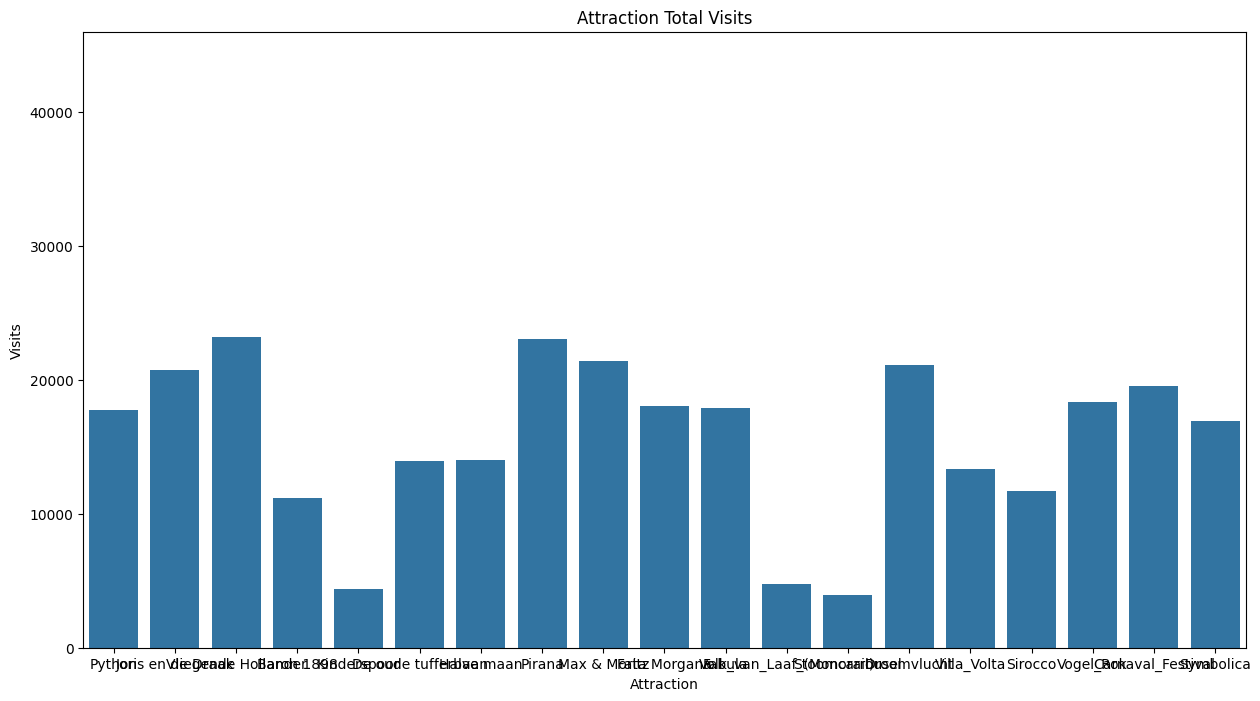

+--------------------------+----------+
| Attraction               |   Visits |
|--------------------------+----------|
| Baron 1898               |    11164 |
| Carnaval_Festival        |    19511 |
| De oude tufferbaan       |    13940 |
| Droomvlucht              |    21102 |
| Fabula                   |    17918 |
| Fata Morgana             |    18008 |
| Halve maan               |    14044 |
| Joris en de Draak        |    20762 |
| Kinderspoor              |     4389 |
| Max & Moritz             |    21377 |
| Pirana                   |    23033 |
| Python                   |    17748 |
| Sirocco                  |    11668 |
| Stoomcarrousel           |     3928 |
| Symbolica                |    16890 |
| Villa_Volta              |    13351 |
| Vliegende Hollander      |    23224 |
| Vogel_Rok                |    18349 |
| Volk_van_Laaf_(Monorail) |     4767 |
+--------------------------+----------+


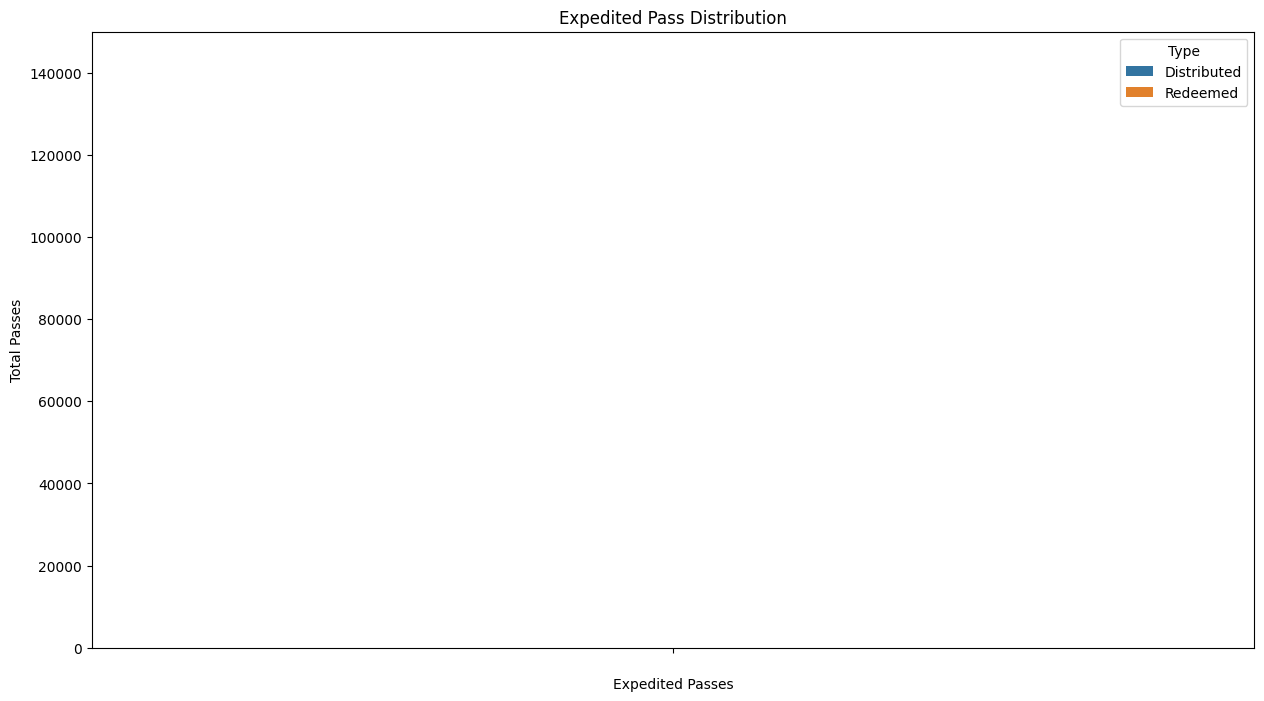

+--------------------+----------------+-------------+
| Expedited Passes   |   Total Passes | Type        |
|--------------------+----------------+-------------|
|                    |              0 | Distributed |
|                    |              0 | Redeemed    |
+--------------------+----------------+-------------+


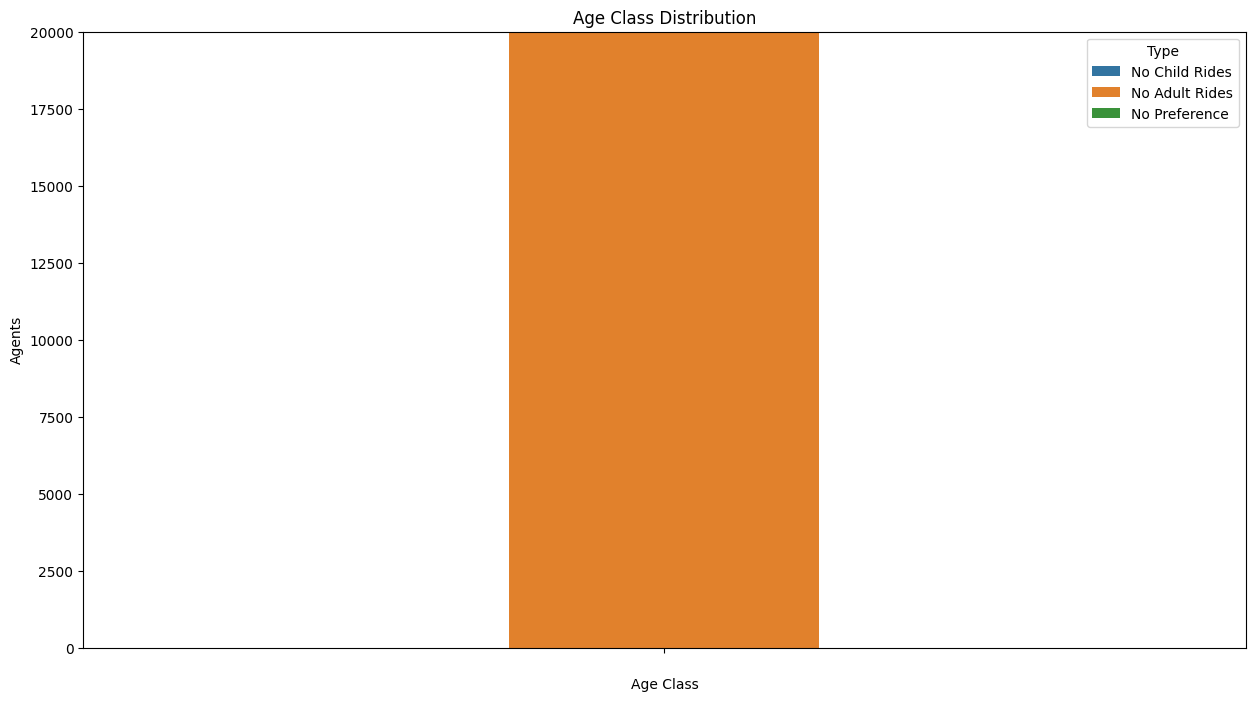

+-------------+----------+----------------+
| Age Class   |   Agents | Type           |
|-------------+----------+----------------|
|             |    40000 | No Adult Rides |
|             |        0 | No Child Rides |
|             |        0 | No Preference  |
+-------------+----------+----------------+
Agent ID: 31661
Agent Archetype: park_tourer


Agent ID: 26158
Agent Archetype: ride_enthusiast


Agent ID: 35222
Agent Archetype: ride_enthusiast


Agent ID: 26905
Agent Archetype: park_tourer


Agent ID: 37562
Agent Archetype: park_tourer




In [9]:
# Initialize Park
RNG_SEED = 1005

park = Park(
    attraction_list=ATTRACTIONS,
    activity_list=ACTIVITIES,
    plot_range=PLOT_RANGE,
    random_seed=RNG_SEED,
    version=VERSION,
    verbosity=VERBOSITY
)

# Build Arrivals

park.generate_arrival_schedule(
    arrival_seed=HOURLY_PERCENT, 
    total_daily_agents=TOTAL_DAILY_AGENTS, 
    perfect_arrivals=PERFECT_ARRIVALS,
)

# Build Agents
park.generate_agents(
    behavior_archetype_distribution=AGENT_ARCHETYPE_DISTRIBUTION,
    exp_ability_pct=EXP_ABILITY_PCT,
    exp_wait_threshold=EXP_THRESHOLD,
    exp_limit=EXP_LIMIT
)

# Build Attractions + Activities
park.generate_attractions()
park.generate_activities()

# Pass Time
for _ in range(len(HOURLY_PERCENT.keys()) * 60):
    park.step()

# Save Parameters of Current Run
sim_parameters = {
    "VERSION": VERSION,
    "VERBOSITY": VERBOSITY,
    "SHOW_PLOTS": SHOW_PLOTS,
    "RNG_SEED": RNG_SEED,
    "TOTAL_DAILY_AGENTS": TOTAL_DAILY_AGENTS,
    "PERFECT_ARRIVALS": PERFECT_ARRIVALS,
    "HOURLY_PERCENT": HOURLY_PERCENT,
    "EXP_ABILITY_PCT": EXP_ABILITY_PCT,
    "EXP_THRESHOLD": EXP_THRESHOLD,
    "EXP_LIMIT": EXP_LIMIT,
    "AGENT_ARCHETYPE_DISTRIBUTION": AGENT_ARCHETYPE_DISTRIBUTION,
    "ATTRACTIONS": ATTRACTIONS,
    "ACTIVITIES": ACTIVITIES,
    "BEHAVIOR_ARCHETYPE_PARAMETERS": BEHAVIOR_ARCHETYPE_PARAMETERS,
}
park.write_data_to_file(
    data=sim_parameters, 
    output_file_path=f"data/{VERSION}/parameters", 
    output_file_format="json"
)

# Store + Print Data
park.make_plots(show=SHOW_PLOTS)
park.print_logs(N = 5)
#park.print_logs(selected_agent_ids = [778])

## Pool of Simulations
Run a set number of runs

In [10]:
def run_multiple_simulations(simulation_runs: int, hourly_percent, attractions, activities, plot_range, total_daily_agents,
                             perfect_arrivals, agent_archetype_distribution, exp_ability_pct, exp_threshold, exp_limit,
                             simplify_park: bool = False, remove_agents: bool = False, remove_attractions: bool = False):
    """
    Run multiple park simulation with given number of hours on multiple threads
    """

    # Initialize simulator parameters
    simulation_data = []
    run_info = (0, hourly_percent, attractions, activities, plot_range, total_daily_agents, perfect_arrivals,
                agent_archetype_distribution, exp_ability_pct, exp_threshold, exp_limit, simplify_park, remove_agents, remove_attractions)
    seed_multiplier = 1000
    for i in range(simulation_runs):
        run_information = (i * seed_multiplier,) + run_info[1:]
        simulation_data.append(run_information)

    # Run simulations
    with Pool() as pool:
        return pool.starmap(simulate, simulation_data)


# Run simulations
runs = 32

print(f"Running simulation on {cpu_count()} cores")

sim_results = run_multiple_simulations(runs, HOURLY_PERCENT, ATTRACTIONS, ACTIVITIES, PLOT_RANGE, TOTAL_DAILY_AGENTS, PERFECT_ARRIVALS, AGENT_ARCHETYPE_DISTRIBUTION, EXP_ABILITY_PCT, EXP_THRESHOLD, EXP_LIMIT, False, True, True)


Running simulation on 32 cores


In [11]:
def print_park_results(average_wait_times: dict[str, float]):
    print_values = []
    for attraction_name, wait_time in average_wait_times.items():
        print_values.append(
            {
                "Attraction": attraction_name,
                "Average Wait Time": wait_time,
                "Queue Type": "Standby"
            }
        )
    df = pd.DataFrame(print_values)
    print(
    tabulate(
        df.sort_values('Attraction'),
        headers='keys',
        tablefmt='psql',
        showindex=False,
        floatfmt=('.2f')
    ))
    

print_park_results(get_average_wait_times(sim_results))
for result in sim_results:
    print_park_results(get_park_average_wait_times(result))


+--------------------------+---------------------+--------------+
| Attraction               |   Average Wait Time | Queue Type   |
|--------------------------+---------------------+--------------|
| Baron 1898               |               41.77 | Standby      |
| Carnaval_Festival        |               30.27 | Standby      |
| De oude tufferbaan       |               28.45 | Standby      |
| Droomvlucht              |               44.61 | Standby      |
| Fabula                   |               18.11 | Standby      |
| Fata Morgana             |               30.55 | Standby      |
| Halve maan               |               29.52 | Standby      |
| Joris en de Draak        |               55.07 | Standby      |
| Kinderspoor              |                7.77 | Standby      |
| Max & Moritz             |               40.51 | Standby      |
| Pirana                   |               37.73 | Standby      |
| Python                   |               42.96 | Standby      |
| Sirocco 

In [12]:
def get_park_results(printed_park: Park):
    avg_queue_wait_time = []
            
    for attraction_name, attraction in printed_park.attractions.items():
        queue_wait_list = [
            val for time, val in attraction.history["queue_wait_time"].items()
            if time <= printed_park.park_close
        ]
        exp_queue_wait_list = [
            val for time, val in attraction.history["exp_queue_wait_time"].items()
            if time <= printed_park.park_close
        ]            
        avg_queue_wait_time.append(
            {
                "Attraction": attraction_name,
                "Average Wait Time": sum(queue_wait_list) / len(queue_wait_list),
                "Queue Type": "Standby"
            }
        )
    
    df = pd.DataFrame(avg_queue_wait_time)
    expected_wait_times = {attraction["name"]: attraction["expected_wait_time"] for attraction in ATTRACTIONS}
    df["Expected Wait Time"] = df.apply(lambda row: expected_wait_times[row["Attraction"]] if row["Queue Type"] == "Standby" else 0, axis=1)
    df["Wait Time Difference"] = abs(df["Expected Wait Time"] - df["Average Wait Time"])
    summed_value = df["Wait Time Difference"].sum()
    #print(
    #tabulate(
    #    df.sort_values('Attraction'),
    #    headers='keys',
    #    tablefmt='psql',
    #    showindex=False,
    #    floatfmt=('.2f')
    #))
    #print(summed_value)
    return summed_value

def get_average_difference(results):
    difference = 0
    for park_value in results:
        difference += get_park_results(park_value)
    return difference / len(results)

## Search distributions
Attempts to find the best distribution to fit attractions




In [13]:
def array_to_distribution(distribution_values: tuple[int]):
    if len(distribution_values) != 6:
        raise ValueError("Must be 6 values")
    
    if sum(distribution_values) != 100:
        raise ValueError(f"Sum must be equal to 100 is {sum(distribution_values)}")
    
    return {
                            "ride_enthusiast": distribution_values[0],
                            "ride_favorer": distribution_values[1],
                            "park_tourer": distribution_values[2],
                            "park_visitor": distribution_values[3],
                            "activity_favorer": distribution_values[4],
                            "activity_enthusiast": distribution_values[5],
                        }

# Generate permutations
iteration_range = range(0, 101, 20)
averages = {}
for ride_enthusiast in iteration_range:
    for ride_favorer in iteration_range:
        for park_tourer in iteration_range:
            for park_visitor in iteration_range:
                for activity_favorer in iteration_range:
                    for activity_enthusiast in iteration_range:
                        data = [ride_enthusiast, ride_favorer, park_tourer, park_visitor, activity_favorer, activity_enthusiast]
                        if sum(data) == 100:
                            averages[tuple(data)] = None
print(len(averages.keys()))
lowest = 1000000000000000000
for key in averages.keys():
    AGENT_ARCHETYPE_DISTRIBUTION = array_to_distribution(key)
    simulation = run_multiple_simulations(16, HOURLY_PERCENT, ATTRACTIONS, ACTIVITIES, PLOT_RANGE, TOTAL_DAILY_AGENTS, PERFECT_ARRIVALS, AGENT_ARCHETYPE_DISTRIBUTION, EXP_ABILITY_PCT, EXP_THRESHOLD, EXP_LIMIT, True, True)
    average = get_average_difference(simulation)
    lowest = min(average, lowest)
    print(f"Result for {key} with {average}")

print(f"Lowest value found: {lowest}")




252
Result for (0, 0, 0, 0, 0, 100) with 620.6517678868553
Result for (0, 0, 0, 0, 20, 80) with 620.3261647254576
Result for (0, 0, 0, 0, 40, 60) with 619.6103785357737
Result for (0, 0, 0, 0, 60, 40) with 617.871713810316
Result for (0, 0, 0, 0, 80, 20) with 615.5741888519134
Result for (0, 0, 0, 0, 100, 0) with 611.6984608985024
Result for (0, 0, 0, 20, 0, 80) with 522.645112312812
Result for (0, 0, 0, 20, 20, 60) with 514.8954242928453
Result for (0, 0, 0, 20, 40, 40) with 504.0141846921798
Result for (0, 0, 0, 20, 60, 20) with 490.7978785357737
Result for (0, 0, 0, 20, 80, 0) with 476.52323211314473
Result for (0, 0, 0, 40, 0, 60) with 396.51657653910155
Result for (0, 0, 0, 40, 20, 40) with 382.451268718802
Result for (0, 0, 0, 40, 40, 20) with 367.5328826955074
Result for (0, 0, 0, 40, 60, 0) with 348.98928868552406
Result for (0, 0, 0, 60, 0, 40) with 275.90551164725457
Result for (0, 0, 0, 60, 20, 20) with 260.1837978369384
Result for (0, 0, 0, 60, 40, 0) with 242.2274126455906